In [1]:
import os
from tqdm import tqdm

import torch
import torchvision
from torchvision import transforms as T
import easyocr

from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Попытка реализовать свой алгоритм
# Общий подход такой:
# С входного изображения выделить строки текста, внутри них выделить символы(буквы)
# И далее обученная на изображениях букв модель делает распознавание

In [3]:
# функция принимающая изображение и возвращающая тензор с одним каналом с контрастом по пикселям
def get_grayscale_tensor(image_path, threshold=0.45, kernel_size=1):
    
    img = Image.open(image_path).convert('L')
    img_tensor = T.ToTensor()(img)
    img_tensor = T.CenterCrop(size=(int(img_tensor.shape[1]*0.9),
                                                         int(img_tensor.shape[2]*0.9)))(img_tensor)
    img_tensor = T.GaussianBlur(kernel_size=kernel_size)(img_tensor)
    
    img_tensor_th = torch.where(img_tensor < threshold, img_tensor,
                                torch.ones(img_tensor.shape[1], img_tensor.shape[2]))
    
    return img_tensor_th

In [4]:
# от тензора получаем словарь, где ключи - изображения(тензоры) мест на скане, 
# где содержится какая-либо графическая информация(в идеале текст, но в данном случае будет много лишнего - печать, фото), 
# а значения - изображения(тензоры) разбиения на возможные символы внутри этого места
# подход такой: ищем промежутки между полностью белыми строками пикселей, 
# в которых содержится какая-то информация, 
# потом внутри получившихся областей делаем тоже самое только как бы по столбцам(вертикали) 
def words_from_text_lines(image_tensor):
    
    rows = []
    for i in range(len(image_tensor[0])):
        if torch.equal(image_tensor[0][i], torch.ones(image_tensor.shape[2],)):
            rows.append(i)
    rows_slice = [(rows[i], rows[i+1]) for i in range(len(rows)-1) if rows[i+1] - rows[i] != 1]
    
    words = []
    for i in range(len(rows_slice)):
        words.append(image_tensor[0][rows_slice[i][0]:rows_slice[i][1] + 1].unsqueeze(0))
    
    word_index_dict = {}
    for word in words:
        permute_word = word.permute(0, 2, 1)
        cols = []
        for i in range(len(permute_word[0])):
            if torch.equal(permute_word[0][i], torch.ones(permute_word.shape[2],)):
                cols.append(i)
        word_index_dict[word] = cols
        
    word_slice_dict = {}
    for key, value in word_index_dict.items():
        word_slice_dict[key] = [(value[i], value[i+1]) for i in range(len(value)-1) if value[i+1] - value[i] != 1]
        
    word_char_dict = {}
    for key in word_slice_dict.keys():
        permute_key = key.permute(0, 2, 1)
        chars = []
        for i in range(len(word_slice_dict[key])):
            char = permute_key[0][word_slice_dict[key][i][0]:word_slice_dict[key][i][1] + 1].unsqueeze(0).permute(0, 2, 1)
            chars.append(char)
        word_char_dict[key] = chars
        
    return word_char_dict

In [5]:
# в результате предыдущей функции мы получаем кусок изображения с фотографией, который нужно разбить еще раз
def get_final_image_samples(word_char_dict):
    
    indexes = []
    for i in range(len(word_char_dict.keys())):
        indexes.append(list(word_char_dict.keys())[i].shape[1])
    max_shape_index = indexes.index(max(indexes))
    
    word_char_dict_2 = {}
    for value in list(word_char_dict.values())[max_shape_index]:
        temp_dict = words_from_text_lines(value)
        word_char_dict_2.update(temp_dict)
        
    del word_char_dict[list(word_char_dict.keys())[max_shape_index]]
    
    word_char_dict.update(word_char_dict_2)
    
    return word_char_dict

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

In [7]:
def show_input(image, title=''):
    image = image.permute(1, 2, 0).numpy()
    plt.figure(figsize=(18,15))
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

In [8]:
# хэлпер функция для даталоадера, RGBA изображения с альфа каналом преобразуем в 1 канал
def custom_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        img.load()
        back = Image.new('RGB', img.size, (255, 255, 255))
        back.paste(img, mask=img.split()[3])
        img_new = ImageOps.invert(back.convert('L'))
        return img_new

In [9]:
# https://github.com/GregVial/CoMNIST
data_path = os.getcwd() + '\\Cyrillic'

In [10]:
symbol_labels = []
for _, subdirs, files in os.walk(data_path):
    for subdir in subdirs:
        symbol_labels.append(subdir)

In [11]:
transformers = T.Compose([T.ToTensor(),
                          T.Resize((28, 28))])
dataset = torchvision.datasets.ImageFolder(root=data_path, transform=transformers, loader=custom_loader)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

In [12]:
images, labels = next(iter(dataloader))

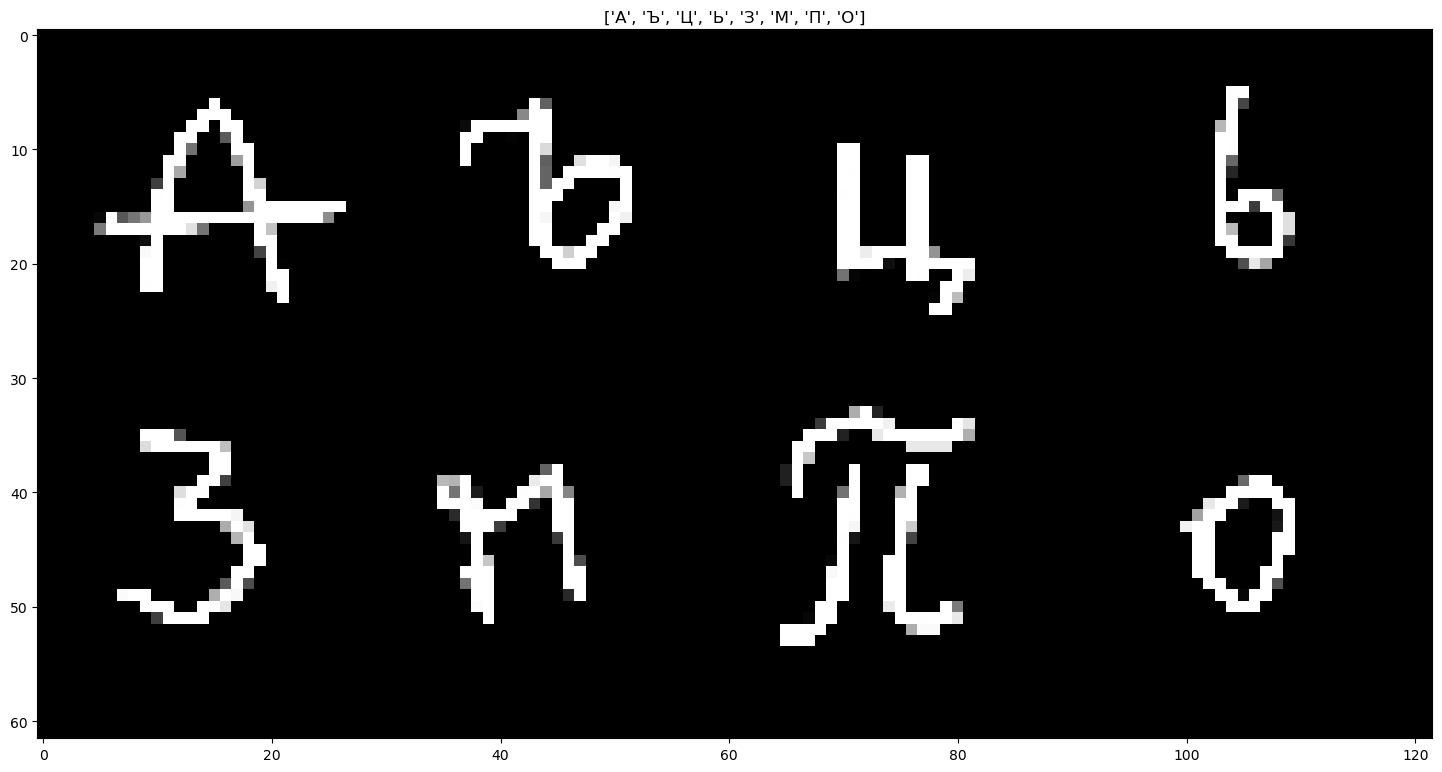

In [13]:
show_input(torchvision.utils.make_grid(images, nrow=4), [symbol_labels[i] for i in labels])

In [14]:
# изначальной идеей была CNN с переносом обучения, но результат оказался еще хуже, чем у простейшей FNN
#model = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
#model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#model.fc = torch.nn.Linear(model.fc.in_features, 34)
#model = model.to(device)

In [15]:
# простейший вариант FNN
class FNN(torch.nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.l1 = torch.nn.Linear(28*28, 500)
        self.relu = torch.nn.ReLU()
        self.l2 = torch.nn.Linear(500, 34)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

In [16]:
model = FNN().to(device)

In [17]:
CEloss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=0.001)

In [18]:
#def train_model_cnn(model, loader, loss_fn, optimizer, n_epochs):
#    
#    train_loss = []
#    
#    for epoch in range(n_epochs):
#        
#        ep_train_loss = []
#        
#        model.train()
#        
#        for image, label in tqdm(loader):
#            optimizer.zero_grad()
#            image = image.to(device)
#            label = label.to(device)
#            predictions = model(image)
#            loss = loss_fn(predictions, label)
#            loss.backward()
#            optimizer.step()
#           ep_train_loss.append(loss.item())
#                
#        print(f'Epoch {epoch + 1} of {n_epochs}')
#                
#        train_loss.append(np.mean(ep_train_loss))
#        
#        print(f"\t training loss: {train_loss[-1]:.6f}")
#        
#    return train_loss

In [19]:
def train_model_fnn(model, loader, loss_fn, optimizer, n_epochs):
    
    train_loss = []
    
    for epoch in range(n_epochs):
        
        ep_train_loss = []
        
        model.train()
        
        for image, label in tqdm(loader):
            optimizer.zero_grad()
            image = image.reshape(-1, 28*28).to(device)
            label = label.to(device)
            predictions = model(image)
            loss = loss_fn(predictions, label)
            loss.backward()
            optimizer.step()
            ep_train_loss.append(loss.item())
                
        print(f'Epoch {epoch + 1} of {n_epochs}')
                
        train_loss.append(np.mean(ep_train_loss))
        
        print(f"\t training loss: {train_loss[-1]:.6f}")
        
    return train_loss

In [20]:
%%time
trains_loss_fnn = train_model_fnn(model, dataloader, CEloss, optimizer, 4)

100%|██████████████████████████████████████████████████████████████████████████████| 1920/1920 [00:30<00:00, 62.88it/s]


Epoch 1 of 4
	 training loss: 1.671998


100%|██████████████████████████████████████████████████████████████████████████████| 1920/1920 [00:28<00:00, 67.68it/s]


Epoch 2 of 4
	 training loss: 0.754104


100%|██████████████████████████████████████████████████████████████████████████████| 1920/1920 [00:28<00:00, 68.16it/s]


Epoch 3 of 4
	 training loss: 0.401288


100%|██████████████████████████████████████████████████████████████████████████████| 1920/1920 [00:28<00:00, 67.55it/s]

Epoch 4 of 4
	 training loss: 0.219617
CPU times: total: 11min 24s
Wall time: 1min 55s


In [21]:
img_path = r'DataForOCR\0.jpeg'

In [22]:
image_tensor = get_grayscale_tensor(img_path)

In [23]:
word_char_dict = words_from_text_lines(image_tensor)

In [24]:
word_char_dict_final = get_final_image_samples(word_char_dict)

In [25]:
# Результат конечно оставляет желать лучшего, но все же некоторые паттерны видны
# МОСКВЫ - МОСЖВЫ, ПРЕСНЕНСКОГО - ПРЕСНЕНСКОТО, ДЖОН - ДЖОМ
# ТРАМП - ТЫЩП, ДОНАЛЬД - ДОНЮБД
# Как будет видно ниже одной из причин является конечно наивный подход разграничивания пикселей, 
# который сильно зависит от качества входного изображения, некоторые буквы имеют общий пограничный пиксель, 
# либо артефакты, 
# а также параметры threshold и kernel в функции предобработки, которые по-разному отрабатывают на разных примерах
# Также возможно для специфики конкретно данной задачи тренировочный набор стоило бы избавить от прописных букв
model.eval()
with torch.no_grad():
    for key in word_char_dict_final.keys():
        word = []
        for value in word_char_dict_final[key]:
            test_tensor = T.functional.invert(value)
            test_tensor = T.Resize((20, 20))(test_tensor)
            test_tensor = T.Pad(4)(test_tensor)
            prediction = model(test_tensor.unsqueeze(0).reshape(-1, 28*28).to(device))
            word.append(symbol_labels[prediction[0].argmax().item()])
        if len(word) > 2:
            print(''.join(word))

ТУЭЬЬЬКСЬЬЗСЬЭСЗЭСССЬЬ
СПДСПОДТЩОЬВИЭОЖЫМОФДЖДЖМЩЕМ
ОВДПРЕСНЕНСКОТОДШОЩДЬ
ЫЮДШОРОДОШМОСЖВЫ
ЬЮСХЦСШОЧЫЭЭДЬЗЗДЕ
IЭIIIIIIIIIУIIЩЬЬЬIIУ
ЩЩШЩШШЭЬАЬШЮМФТТТТУТТТТЖЖЮ
ТЫЩП
ЖЖЬЖЬ
ЭЗЖМШЩ
ЖГХ
ЬЬЖ
ДОНЮБД
ДЖОМ
ССЗЩСОБСЗЭ
РОДСКРЩНС
ТДТЫБЮЫИОР


In [30]:
test1 = T.functional.invert(list(word_char_dict_final.values())[10][0])
test1 = T.Resize((20, 20))(test1)
test1 = T.Pad(4)(test1)

test2 = T.functional.invert(list(word_char_dict_final.values())[10][1])
test2 = T.Resize((20, 20))(test2)
test2 = T.Pad(4)(test2)

test3 = T.functional.invert(list(word_char_dict_final.values())[10][2])
test3 = T.Resize((20, 20))(test3)
test3 = T.Pad(4)(test3)

test4 = T.functional.invert(list(word_char_dict_final.values())[10][3])
test4 = T.Resize((20, 20))(test4)
test4 = T.Pad(4)(test4)

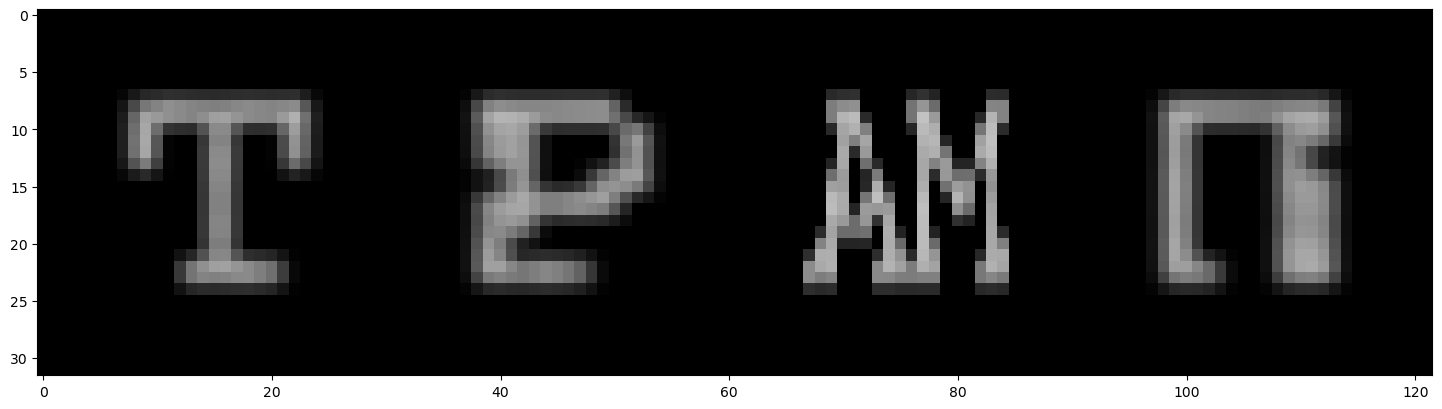

In [31]:
show_input(torchvision.utils.make_grid([test1, test2, test3, test4], nrow=4))

In [32]:
img_test = T.functional.to_pil_image(image_tensor)

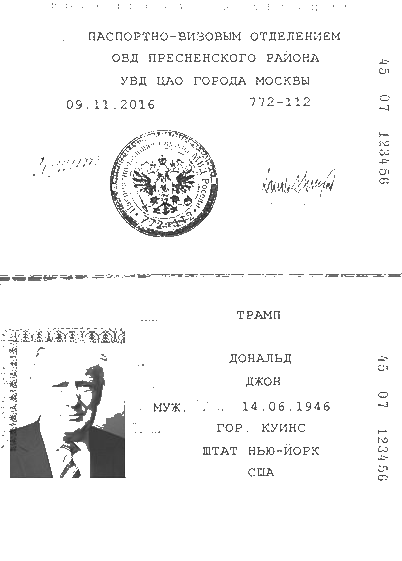

In [33]:
img_test

In [34]:
# EasyOCR

In [35]:
reader = easyocr.Reader(['ru'], gpu=True)
result = reader.readtext(img_path)
result

[([[101, 31], [225, 31], [225, 45], [101, 45]],
  'С с и и с к ; я',
  0.4927065279142246),
 ([[271, 31], [313, 31], [313, 47], [271, 47]], '4 Е ₽', 0.7425159118558317),
 ([[109, 59], [365, 59], [365, 78], [109, 78]],
  'ПАСПОРТНО-визовым ОтДЕЛЕНИЕМ',
  0.4648561981603755),
 ([[133, 83], [163, 83], [163, 99], [133, 99]], 'овд', 0.9807525468379047),
 ([[168, 82], [280, 82], [280, 96], [168, 96]],
  'ПРЕСНЕНСКОГО',
  0.828364038574049),
 ([[287, 81], [343, 81], [343, 97], [287, 97]], 'РАЙОНА', 0.9998547266671952),
 ([[139, 105], [335, 105], [335, 121], [139, 121]],
  'УВД ЦАО ГОРОДА МОСКВЫ',
  0.6846751131319015),
 ([[87, 129], [179, 129], [179, 145], [87, 145]],
  '09.11.2016',
  0.7248729966936491),
 ([[192, 133], [237, 133], [237, 145], [192, 145]],
  'аарачагыы',
  0.06257738261801038),
 ([[269, 127], [335, 127], [335, 143], [269, 143]],
  '772-112',
  0.7325917297012998),
 ([[399, 169], [415, 169], [415, 201], [399, 201]], '&', 0.4180026239312298),
 ([[278, 196], [363, 196], [363, 2